In [1]:
import transformers

print("Transformers Version:", transformers.__version__)


Transformers Version: 4.27.4


In [2]:
import warnings
from transformers import logging

warnings.filterwarnings('ignore')
logging.set_verbosity_error()


In [3]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)


In [4]:
import datasets
import pandas as pd
from ast import literal_eval
datasets.disable_caching()

data_dir = '/kaggle/input/vispamdataset-v2/preprocessed/'

def load_data(data_dir):
    train_df = pd.read_csv(data_dir + 'train.csv', converters={'categories': literal_eval})
    dev_df = pd.read_csv(data_dir + 'dev.csv', converters={'categories': literal_eval})
    test_df = pd.read_csv(data_dir + 'test.csv', converters={'categories': literal_eval})
    
    train_dataset = datasets.Dataset.from_dict(train_df)
    dev_dataset = datasets.Dataset.from_dict(dev_df)
    test_dataset = datasets.Dataset.from_dict(test_df)
    dataset_dict = datasets.DatasetDict({'train': train_dataset, 'dev': dev_dataset, 'test': test_dataset})
    
    return dataset_dict

vispam_datasets = load_data(data_dir)


In [5]:
categories = set(vispam_datasets['train']['category'] + vispam_datasets['dev']['category'] + vispam_datasets['test']['category'])
category2idx = {p:i for i, p in enumerate(categories)}
num_categories = len(category2idx)
print("Number of categories:", num_categories)


Number of categories: 12


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MetaParamManager():
    
    def __init__(self):
        self.meta_em = {}

    def state_dict(self):
        return self.meta_em

    def register(self, name, param):
        self.meta_em[name] = param
        

class BasicLinear(nn.Module):
    
    def __init__(self, state_size, num_classes):
        super(BasicLinear, self).__init__()
        self.W = nn.Linear(state_size, num_classes, bias=False)

    def forward(self, x):
        out = self.W(x)
        return out
    
    
class CustLinear(nn.Module):
    
    def __init__(self, meta_units, state_size, num_classes, meta_param_manager):
        super(CustLinear, self).__init__()
        
        self.state_size = state_size
        self.num_classes = num_classes
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, state_size*num_classes))
            meta_param_manager.register("CustLinear." + name, getattr(self, name).weight)

    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        W = torch.cat([getattr(self, name)(idx).view(x.shape[0], self.state_size, self.num_classes) for name, idx in kwargs.items()], dim=1)
        x = x.unsqueeze(dim=1).repeat(1, 1, len(kwargs))
        out = torch.bmm(x, W).squeeze(dim=1)
        return out
    
    
class BasisCustLinear(nn.Module):
    
    def __init__(self, meta_units, meta_dim, key_query_size, state_size, num_bases, num_classes, meta_param_manager):
        super(BasisCustLinear, self).__init__()
        
        self.state_size = state_size
        self.num_classes = num_classes
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustLinear." + name, getattr(self, name).weight)

        self.P = nn.Sequential(
            nn.Linear(meta_dim*len(meta_units), key_query_size),  # From MetaData to Query
            nn.Tanh(),
            # Calculate weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            nn.Linear(num_bases, state_size * num_classes),  # Weighted Sum of Bases
        )
        
    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        W = self.P(conc).view(x.shape[0], self.state_size, self.num_classes)
        out = torch.bmm(x.unsqueeze(dim=1), W).squeeze(dim=1)
        return out
    
    
class BasicBias(nn.Module):
    
    def __init__(self, num_classes):
        super(BasicBias, self).__init__()
        self.b = nn.Parameter(torch.zeros((1, num_classes)))

    def forward(self):
        return self.b
    
    
class CustBias(nn.Module):
    
    def __init__(self, meta_units, state_size, num_classes, meta_param_manager):
        super(CustBias, self).__init__()
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, state_size))
            meta_param_manager.register("CustBias." + name, getattr(self, name).weight)
            
        self.Y = nn.Linear(state_size*len(meta_units), num_classes, bias=False)

    def forward(self, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        out = self.Y(conc)
        return out
    
    
class BasisCustBias(nn.Module):
    
    def __init__(self, meta_units, meta_dim, state_size, key_query_size, num_bases, num_classes, meta_param_manager):
        super(BasisCustBias, self).__init__()
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustBias." + name, getattr(self, name).weight)

        self.P = nn.Sequential(
            # From MetaData to Query
            nn.Linear(meta_dim*len(meta_units), key_query_size),
            nn.Tanh(),
            # Calculate Weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            # Weighted Sum of Bases
            nn.Linear(num_bases, state_size),
        )
        
        self.Y = nn.Linear(state_size, num_classes, bias=False)

    def forward(self, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        out = self.Y(self.P(conc))
        return out
    

In [7]:
from torch import nn
from transformers import AutoModel, BertModel

class ViSpam_Classifier(nn.Module):
    
    def __init__(self, model_name, task, freeze_bert=False, drop=0.3):
        super(ViSpam_Classifier, self).__init__()
        
        self.model_name = model_name
        name, model_type = model_name.split('_')
        
        assert name in ['PhoBERT', 'BERT4News', 'ViBERT']
        assert model_type in ['CustBias', 'CustLinear', 'BasisCustBias', 'BasisCustLinear']
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.freeze_bert = freeze_bert
        self.drop = drop
        
        self.meta_dim = 64
        self.key_query_size = 64
        self.num_bases = 4
        
        self.meta_param_manager = MetaParamManager()
        self.meta_units = [('category_id', num_categories)]
        
        if name == 'PhoBERT':
            self.bert = AutoModel.from_pretrained('vinai/phobert-base')
        elif name == 'BERT4News':
            self.bert = BertModel.from_pretrained('NlpHUST/vibert4news-base-cased')
        else:
            self.bert = AutoModel.from_pretrained('FPTAI/vibert-base-cased')
            
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
                
        self.state_size = 768
        
        # self.drop = nn.Dropout(drop)
        # self.fc = nn.Linear(self.bert.config.hidden_size, self.state_size)
        # nn.init.normal_(self.fc.weight, std=0.02)
        # nn.init.normal_(self.fc.bias, 0)
        
        # Linear
        if model_type == 'CustLinear':
            self.W = CustLinear(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustLinear':
            self.W = BasisCustLinear(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                key_query_size=self.key_query_size,
                state_size=self.state_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.W = BasicLinear(state_size=self.state_size, num_classes=self.num_classes)
            
        # Bias
        if model_type == 'CustBias':
            self.bias = CustBias(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustBias':
            self.bias = BasisCustBias(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                state_size=self.state_size,
                key_query_size=self.key_query_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.bias = BasicBias(self.num_classes)
        
    def forward(self, input_ids, attention_mask, category_id):
        batch_size, sequence_length = input_ids.shape
        last_hidden_state, output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        
        # output = self.drop(bert_output)
        # output = self.fc(output)
        
        if 'CustLinear' in self.model_name:
            x = self.W(output, category_id)
        else:
            x = self.W(output)

        if 'CustBias' in self.model_name:
            x += self.bias(category_id)
        else:
            x += self.bias()

        return x
    

In [8]:
import torch
import numpy as np

class EarlyStopping:
    
    def __init__(self, patience=5, verbose=True, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
            
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        

In [9]:
import os
import gc
import json
import torch
from torch import nn
import numpy as np
from scipy import interpolate
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot

def train_step(model, criterion, optimizer, train_dataloader, task):
    model.train()
    losses = []
    correct = 0
    
    trues = []
    predicts = []

    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(train_dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        category_id = data['category_id'].to(device)
        labels = data[label_column].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, category_id=category_id)

        loss = criterion(outputs, labels)
        pred = torch.max(outputs, dim=1)[1]
        
        correct += torch.sum(pred == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()
        
        trues.extend(labels.cpu().detach().numpy())
        predicts.extend(pred.cpu().detach().numpy())

    accuracy = correct.double().cpu().data.numpy()/len(train_dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def validation_step(model, criterion, dataloader, task):
    model.eval()
    losses = []
    correct = 0
    
    trues = []
    predicts = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            category_id = data['category_id'].to(device)
            labels = data[label_column].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, category_id=category_id)
            pred = torch.max(outputs, dim=1)[1]
            
            loss = criterion(outputs, labels)
            correct += torch.sum(pred == labels)
            losses.append(loss.item())
            
            trues.extend(labels.cpu().detach().numpy())
            predicts.extend(pred.cpu().detach().numpy())
            
    accuracy = correct.double().cpu().data.numpy()/len(dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task):
    torch.cuda.empty_cache()
    gc.collect()
    
    Path(model.model_name).mkdir(parents=True, exist_ok=True)
    
    if early_stopping:
        path_checkpoint = os.path.join(model.model_name, f"{model.model_name}_checkpoint_({task}).pth")
        early_stopping.path = path_checkpoint
    
    best_f1 = 0
    best_model_path = os.path.join(model.model_name, f"{model.model_name}_best_model_({task}).pth")
    last_model_path = os.path.join(model.model_name, f"{model.model_name}_last_model_({task}).pth")
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-"*50)
        
        train_accuracy, train_f1, train_loss = train_step(model, criterion, optimizer, train_dataloader, task)
        val_accuracy, val_f1, val_loss = validation_step(model, criterion, val_dataloader, task)
        
        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print("Train Accuracy: {:.4f} - Train F1-score: {:.4f} - Train Loss: {:.4f}".format(train_accuracy, train_f1, train_loss))
        print("Valid Accuracy: {:.4f} - Valid F1-score: {:.4f} - Valid Loss: {:.4f}".format(val_accuracy, val_f1, val_loss))
        
        if val_f1 > best_f1:
            torch.save(model.state_dict(), best_model_path)
            best_f1 = val_f1
        
        if epoch + 1 == epochs:
            torch.save(model.state_dict(), last_model_path)
            
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                torch.save(model.state_dict(), last_model_path)
                print("Early stopping.")
                break
    
    history_path = os.path.join(model.model_name, f"{model.model_name}_history_({task}).json")
    with open(history_path, 'w') as f:
        json.dump(history, f)
        
    # with open(history_path) as f:
    #     history = json.load(f)
    
    return history


def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'

    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        category_id = data['category_id'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, category_id=category_id)
            
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)
    
    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))
    
    return test_cm


def save_visualization_history(history, model_name, task):
    if len(history['train_loss']) <= 1:
        return False
    
    colors = plt.get_cmap('tab10').colors

    epochs = np.arange(1, len(history['train_loss']) + 1)
    xnew = np.linspace(epochs[0], epochs[-1], 300)
    
    train_loss_smooth = interpolate.interp1d(epochs, history['train_loss'], kind='linear')(xnew)
    val_loss_smooth = interpolate.interp1d(epochs, history['val_loss'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_loss_smooth, color=colors[0], linewidth=3, label='Training Loss')
    ax.plot(xnew, val_loss_smooth, color=colors[1], linewidth=3, label='Validation Loss')
    ax.set_title('Training and Validation Loss', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Loss', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    
    file_name = os.path.join(model_name, f"{model_name}_loss_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    train_acc_smooth = interpolate.interp1d(epochs, history['train_acc'], kind='linear')(xnew)
    val_acc_smooth = interpolate.interp1d(epochs, history['val_acc'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_acc_smooth, color=colors[2], linewidth=3, label='Training Accuracy')
    ax.plot(xnew, val_acc_smooth, color=colors[4], linewidth=3, label='Validation Accuracy')
    ax.set_title('Training and Validation Accuracy', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Accuracy', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    
    file_name = os.path.join(model_name, f"{model_name}_accuracy_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)


def plotting_history(history):
    assert len(history['train_loss']) == len(history['val_loss'])
    assert len(history['train_acc']) == len(history['val_acc'])
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"), shared_yaxes=False, shared_xaxes=False, vertical_spacing=0.1, horizontal_spacing=0.05)
    
    num_epochs = len(history['train_loss'])
    epoch_labels = list(range(1, num_epochs+1))

    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_loss'], name='train_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_loss'], name='val_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_acc'], name='train_accuracy', legendgroup='2'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_acc'], name='val_accuracy', legendgroup='2'), row=1, col=2)

    fig.update_layout(legend=dict(orientation="h", xanchor="center", x=0.5), showlegend=True)
    fig.show()
    
    
def plotting_confusion_matrix(confusion_matrix, task):
    if task == 1:
        labels = ['no-spam', 'spam']
        font_size = 30
    else:
        labels = ['no-spam', 'spam-1', 'spam-2', 'spam-3']
        font_size = 22
        
    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})
    plt.show()
    

In [10]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("FPTAI/vibert-base-cased")

def encode_mapping(examples):
    text_encoded = tokenizer(examples["clean_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)
    category_ids = [category2idx[category] for category in examples['category']]
    text_encoded.update({"category_id": category_ids})
    
    return text_encoded


encoded_datasets = vispam_datasets.map(encode_mapping, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [11]:
import torch
import numpy as np
from sklearn.utils import class_weight

labels = vispam_datasets['train']['label']
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

spam_labels = vispam_datasets['train']['spam_label']
spam_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(spam_labels), y=spam_labels)
spam_class_weights = torch.tensor(spam_class_weights, dtype=torch.float)

class_weights, spam_class_weights

(tensor([0.6797, 1.8909]), tensor([ 0.3399, 16.9242,  3.2375,  1.4499]))

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)


# ViBERT - Cust Bias

## Task 1

In [14]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="ViBERT_CustBias", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8284 - Train F1-score: 0.7864 - Train Loss: 0.4232
Valid Accuracy: 0.8792 - Valid F1-score: 0.8312 - Valid Loss: 0.4539
Validation loss decreased (inf --> 0.453881). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9032 - Train F1-score: 0.8772 - Train Loss: 0.3006
Valid Accuracy: 0.8603 - Valid F1-score: 0.8212 - Valid Loss: 0.3800
Validation loss decreased (0.453881 --> 0.380004). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9369 - Train F1-score: 0.9191 - Train Loss: 0.2282
Valid Accuracy: 0.8798 - Valid F1-score: 0.8347 - Valid Loss: 0.5478
EarlyStopping counter: 1 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9581 - Train F1-score: 0.9459 - Train Loss: 0.1832
Valid Accuracy: 0.8735 - Valid F1-score: 0.8328 - Valid Loss: 0.7859
EarlyStopping counter: 2 out of 3
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9730 - Train F1-score: 0.9653 - Train Loss: 0.1328
Valid Accuracy: 0.8836 - Valid F1-score: 0.8357 - Valid Loss: 0.8109
EarlyStopping counter: 3 out of 3
Early stopping.


In [15]:
save_visualization_history(history, 'ViBERT_CustBias', task=1)
plotting_history(history)


In [16]:
import os
import torch

model_name = "ViBERT_CustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8794
Precision: 0.8626
Recall: 0.8165
F1-score: 0.8354
Confusion matrix:
 [[2767  144]
 [ 334  718]]
              precision    recall  f1-score   support

           0     0.8923    0.9505    0.9205      2911
           1     0.8329    0.6825    0.7503      1052

    accuracy                         0.8794      3963
   macro avg     0.8626    0.8165    0.8354      3963
weighted avg     0.8765    0.8794    0.8753      3963



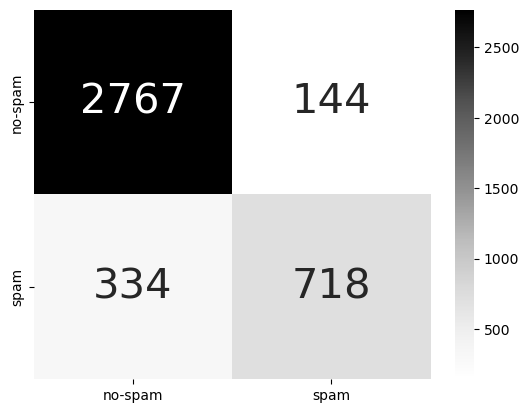

In [17]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [18]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="ViBERT_CustBias", task=2).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7508 - Train F1-score: 0.5694 - Train Loss: 0.8254
Valid Accuracy: 0.8326 - Valid F1-score: 0.6343 - Valid Loss: 0.7896
Validation loss decreased (inf --> 0.789583). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8626 - Train F1-score: 0.7227 - Train Loss: 0.5787
Valid Accuracy: 0.8458 - Valid F1-score: 0.6314 - Valid Loss: 0.8686
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9109 - Train F1-score: 0.8105 - Train Loss: 0.4234
Valid Accuracy: 0.8446 - Valid F1-score: 0.6310 - Valid Loss: 0.9317
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9420 - Train F1-score: 0.8729 - Train Loss: 0.3285
Valid Accuracy: 0.8615 - Valid F1-score: 0.6716 - Valid Loss: 1.3137
EarlyStopping counter: 3 out of 3
Early stopping.


In [19]:
save_visualization_history(history, 'ViBERT_CustBias', task=2)
plotting_history(history)


In [20]:
import os
import torch

model_name = "ViBERT_CustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8589
Precision: 0.6928
Recall: 0.6710
F1-score: 0.6810
Confusion matrix:
 [[2666   16  135   94]
 [  20   24    3    7]
 [ 134    2  161   12]
 [ 116    4   16  553]]
              precision    recall  f1-score   support

           0     0.9080    0.9158    0.9119      2911
           1     0.5217    0.4444    0.4800        54
           2     0.5111    0.5210    0.5160       309
           3     0.8303    0.8026    0.8162       689

    accuracy                         0.8589      3963
   macro avg     0.6928    0.6710    0.6810      3963
weighted avg     0.8583    0.8589    0.8585      3963



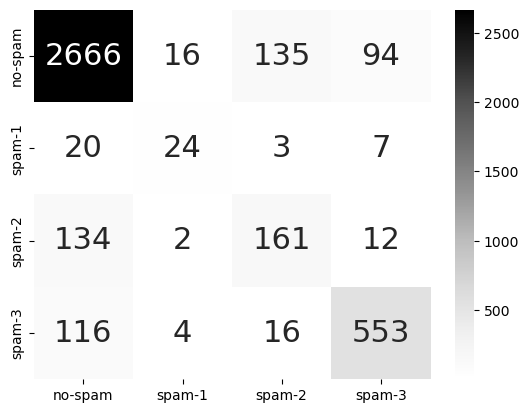

In [21]:
plotting_confusion_matrix(test_cm, task=2)


# ViBERT - Basis Cust Bias

## Task 1

In [22]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="ViBERT_BasisCustBias", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8354 - Train F1-score: 0.7921 - Train Loss: 0.4336
Valid Accuracy: 0.8609 - Valid F1-score: 0.8255 - Valid Loss: 0.3738
Validation loss decreased (inf --> 0.373778). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8979 - Train F1-score: 0.8700 - Train Loss: 0.3090
Valid Accuracy: 0.8660 - Valid F1-score: 0.8273 - Valid Loss: 0.3558
Validation loss decreased (0.373778 --> 0.355809). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9364 - Train F1-score: 0.9184 - Train Loss: 0.2327
Valid Accuracy: 0.8641 - Valid F1-score: 0.8252 - Valid Loss: 0.5839
EarlyStopping counter: 1 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9593 - Train F1-score: 0.9473 - Train Loss: 0.1875
Valid Accuracy: 0.8829 - Valid F1-score: 0.8362 - Valid Loss: 0.7439
EarlyStopping counter: 2 out of 3
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9731 - Train F1-score: 0.9655 - Train Loss: 0.1320
Valid Accuracy: 0.8729 - Valid F1-score: 0.8321 - Valid Loss: 0.8448
EarlyStopping counter: 3 out of 3
Early stopping.


In [23]:
save_visualization_history(history, 'ViBERT_BasisCustBias', task=1)
plotting_history(history)


In [24]:
import os
import torch

model_name = "ViBERT_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8695
Precision: 0.8323
Recall: 0.8341
F1-score: 0.8332
Confusion matrix:
 [[2648  263]
 [ 254  798]]
              precision    recall  f1-score   support

           0     0.9125    0.9097    0.9111      2911
           1     0.7521    0.7586    0.7553      1052

    accuracy                         0.8695      3963
   macro avg     0.8323    0.8341    0.8332      3963
weighted avg     0.8699    0.8695    0.8697      3963



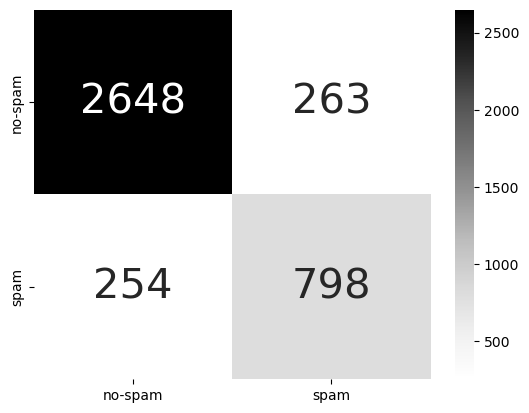

In [25]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [26]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="ViBERT_BasisCustBias", task=2).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7555 - Train F1-score: 0.5724 - Train Loss: 0.7971
Valid Accuracy: 0.8326 - Valid F1-score: 0.6201 - Valid Loss: 0.8066
Validation loss decreased (inf --> 0.806594). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8652 - Train F1-score: 0.7324 - Train Loss: 0.5627
Valid Accuracy: 0.8534 - Valid F1-score: 0.6514 - Valid Loss: 0.8713
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9072 - Train F1-score: 0.7988 - Train Loss: 0.4488
Valid Accuracy: 0.8615 - Valid F1-score: 0.6394 - Valid Loss: 0.9928
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9413 - Train F1-score: 0.8726 - Train Loss: 0.3332
Valid Accuracy: 0.8641 - Valid F1-score: 0.6581 - Valid Loss: 1.5341
EarlyStopping counter: 3 out of 3
Early stopping.


In [27]:
save_visualization_history(history, 'ViBERT_BasisCustBias', task=2)
plotting_history(history)


In [28]:
import os
import torch

model_name = "ViBERT_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8597
Precision: 0.7313
Recall: 0.6675
F1-score: 0.6879
Confusion matrix:
 [[2646    8  160   97]
 [  23   21    1    9]
 [ 127    0  167   15]
 [  99    1   16  573]]
              precision    recall  f1-score   support

           0     0.9140    0.9090    0.9115      2911
           1     0.7000    0.3889    0.5000        54
           2     0.4855    0.5405    0.5115       309
           3     0.8256    0.8316    0.8286       689

    accuracy                         0.8597      3963
   macro avg     0.7313    0.6675    0.6879      3963
weighted avg     0.8623    0.8597    0.8603      3963



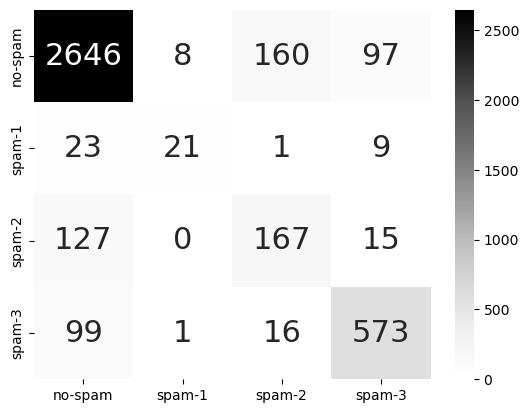

In [29]:
plotting_confusion_matrix(test_cm, task=2)


# ViBERT - Cust Linear

## Task 1

In [30]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="ViBERT_CustLinear", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7994 - Train F1-score: 0.7542 - Train Loss: 0.5196
Valid Accuracy: 0.8225 - Valid F1-score: 0.7851 - Valid Loss: 0.4470
Validation loss decreased (inf --> 0.446956). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8881 - Train F1-score: 0.8590 - Train Loss: 0.3429
Valid Accuracy: 0.8376 - Valid F1-score: 0.8021 - Valid Loss: 0.4559
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9313 - Train F1-score: 0.9122 - Train Loss: 0.2437
Valid Accuracy: 0.8722 - Valid F1-score: 0.8330 - Valid Loss: 0.5574
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9615 - Train F1-score: 0.9505 - Train Loss: 0.1764
Valid Accuracy: 0.8678 - Valid F1-score: 0.8246 - Valid Loss: 0.8642
EarlyStopping counter: 3 out of 3
Early stopping.


In [31]:
save_visualization_history(history, 'ViBERT_CustLinear', task=1)
plotting_history(history)


In [32]:
import os
import torch

model_name = "ViBERT_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8781
Precision: 0.8473
Recall: 0.8354
F1-score: 0.8410
Confusion matrix:
 [[2697  214]
 [ 269  783]]
              precision    recall  f1-score   support

           0     0.9093    0.9265    0.9178      2911
           1     0.7854    0.7443    0.7643      1052

    accuracy                         0.8781      3963
   macro avg     0.8473    0.8354    0.8410      3963
weighted avg     0.8764    0.8781    0.8771      3963



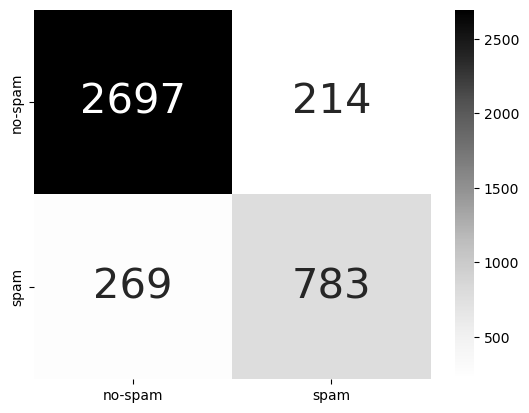

In [33]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [34]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="ViBERT_CustLinear", task=2).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.6595 - Train F1-score: 0.4604 - Train Loss: 1.1556
Valid Accuracy: 0.8225 - Valid F1-score: 0.5658 - Valid Loss: 0.9697
Validation loss decreased (inf --> 0.969664). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8277 - Train F1-score: 0.6738 - Train Loss: 0.6995
Valid Accuracy: 0.7885 - Valid F1-score: 0.5904 - Valid Loss: 0.8650
Validation loss decreased (0.969664 --> 0.865012). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8895 - Train F1-score: 0.7729 - Train Loss: 0.4940
Valid Accuracy: 0.8477 - Valid F1-score: 0.6270 - Valid Loss: 0.9581
EarlyStopping counter: 1 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9336 - Train F1-score: 0.8606 - Train Loss: 0.3555
Valid Accuracy: 0.8553 - Valid F1-score: 0.6139 - Valid Loss: 1.5374
EarlyStopping counter: 2 out of 3
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9605 - Train F1-score: 0.9102 - Train Loss: 0.2549
Valid Accuracy: 0.8634 - Valid F1-score: 0.6245 - Valid Loss: 1.8934
EarlyStopping counter: 3 out of 3
Early stopping.


In [35]:
save_visualization_history(history, 'ViBERT_CustLinear', task=2)
plotting_history(history)


In [36]:
import os
import torch

model_name = "ViBERT_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8660
Precision: 0.6990
Recall: 0.6568
F1-score: 0.6757
Confusion matrix:
 [[2738    9  103   61]
 [  18   26    2    8]
 [ 162    1  132   14]
 [ 125   16   12  536]]
              precision    recall  f1-score   support

           0     0.8998    0.9406    0.9197      2911
           1     0.5000    0.4815    0.4906        54
           2     0.5301    0.4272    0.4731       309
           3     0.8659    0.7779    0.8196       689

    accuracy                         0.8660      3963
   macro avg     0.6990    0.6568    0.6757      3963
weighted avg     0.8596    0.8660    0.8616      3963



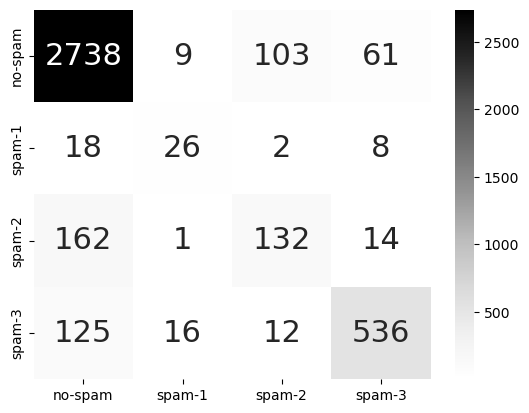

In [37]:
plotting_confusion_matrix(test_cm, task=2)


# ViBERT - Basis Cust Linear

## Task 1

In [38]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="ViBERT_BasisCustLinear", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8279 - Train F1-score: 0.7870 - Train Loss: 0.4407
Valid Accuracy: 0.8534 - Valid F1-score: 0.8160 - Valid Loss: 0.4037
Validation loss decreased (inf --> 0.403718). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8926 - Train F1-score: 0.8651 - Train Loss: 0.3068
Valid Accuracy: 0.8760 - Valid F1-score: 0.8372 - Valid Loss: 0.4434
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9372 - Train F1-score: 0.9195 - Train Loss: 0.2303
Valid Accuracy: 0.8597 - Valid F1-score: 0.8237 - Valid Loss: 0.4356
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9595 - Train F1-score: 0.9481 - Train Loss: 0.1708
Valid Accuracy: 0.8798 - Valid F1-score: 0.8350 - Valid Loss: 0.9745
EarlyStopping counter: 3 out of 3
Early stopping.


In [39]:
save_visualization_history(history, 'ViBERT_BasisCustLinear', task=1)
plotting_history(history)


In [40]:
import os
import torch

model_name = "ViBERT_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8731
Precision: 0.8456
Recall: 0.8195
F1-score: 0.8311
Confusion matrix:
 [[2718  193]
 [ 310  742]]
              precision    recall  f1-score   support

           0     0.8976    0.9337    0.9153      2911
           1     0.7936    0.7053    0.7469      1052

    accuracy                         0.8731      3963
   macro avg     0.8456    0.8195    0.8311      3963
weighted avg     0.8700    0.8731    0.8706      3963



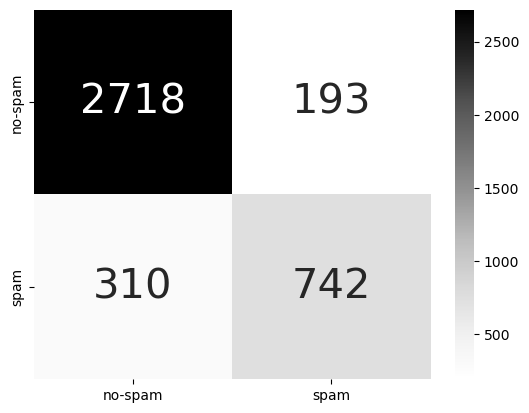

In [41]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [42]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="ViBERT_BasisCustLinear", task=2).to(device)
print(model)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


ViSpam_Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(38168, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7527 - Train F1-score: 0.5826 - Train Loss: 0.8246
Valid Accuracy: 0.8043 - Valid F1-score: 0.5940 - Valid Loss: 0.8260
Validation loss decreased (inf --> 0.825951). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8559 - Train F1-score: 0.7271 - Train Loss: 0.5350
Valid Accuracy: 0.8628 - Valid F1-score: 0.6473 - Valid Loss: 0.8937
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9123 - Train F1-score: 0.8086 - Train Loss: 0.3964
Valid Accuracy: 0.8597 - Valid F1-score: 0.6397 - Valid Loss: 1.0684
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9476 - Train F1-score: 0.8875 - Train Loss: 0.2794
Valid Accuracy: 0.8483 - Valid F1-score: 0.6236 - Valid Loss: 1.3834
EarlyStopping counter: 3 out of 3
Early stopping.


In [43]:
save_visualization_history(history, 'ViBERT_BasisCustLinear', task=2)
plotting_history(history)


In [44]:
import os
import torch

model_name = "ViBERT_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8496
Precision: 0.7340
Recall: 0.6809
F1-score: 0.6840
Confusion matrix:
 [[2574    4  259   74]
 [  25   19    2    8]
 [  95    1  204    9]
 [  97    2   20  570]]
              precision    recall  f1-score   support

           0     0.9223    0.8842    0.9028      2911
           1     0.7308    0.3519    0.4750        54
           2     0.4206    0.6602    0.5139       309
           3     0.8623    0.8273    0.8444       689

    accuracy                         0.8496      3963
   macro avg     0.7340    0.6809    0.6840      3963
weighted avg     0.8701    0.8496    0.8565      3963



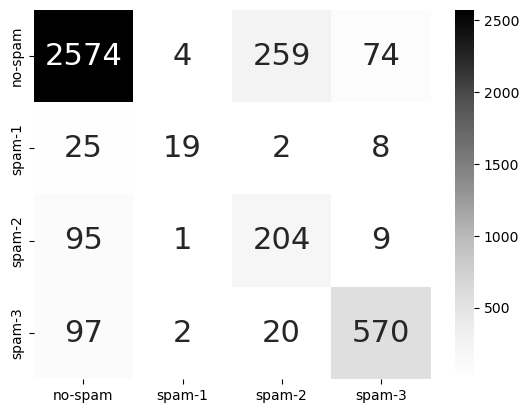

In [45]:
plotting_confusion_matrix(test_cm, task=2)
